### TO DO
* R Studio generate adjacency matrix 
* fix load input into module 
* fix select two countries preferably Brazil ...
* Make sure outbreak occurs at least in initial Province!

In [1]:
#============================================================================================
#    Load required Modules
#============================================================================================
from __future__ import (absolute_import, print_function, division,
                        unicode_literals)
# Append to sys path to ensure that own modules are found
import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]), 'src'))

# Load EMA Workbench to run model
from ema_workbench.util import ema_logging, save_results
from ema_workbench.em_framework import (ModelEnsemble, ModelStructureInterface,
                                        ParameterUncertainty,
                                        CategoricalUncertainty,
                                        Outcome)

# Load Runner for multi_regional models
from multi_model import control
from multi_model.control import  Multi_models, Flight_Matrix

# Load Function that generates list that maps the simulation timestep to month
import util.MonthlyDataExtractor as MonthlyDataExtractor

# Load Python Modules for handling data
from itertools import cycle
import numpy as np
import pandas as pd
import geopandas as gp
#============================================================================================
#    Set up monthyly
#============================================================================================
Simulation_time = 69
control.Simulation_time = Simulation_time

Month_before_startup = 6 # June
lst_sim_time_month = MonthlyDataExtractor.set_up(Simulation_time, Month_before_startup)
#============================================================================================
#    Load simulation input data
#============================================================================================
model_elements = gp.read_file('preprocessing_results/geojson/gdf_model_elements.geojson')
model_elements['i'] = model_elements.index
model_elements = model_elements.set_index('index')
model_elements['perc_pover'] = model_elements['perc_pover']/100
me = len(model_elements)

Region_initially_infected = 92 # Region 92 (Recife is initially infected)
e = model_elements.ix[Region_initially_infected]['i'] # Lookup index position
outc = pd.read_csv(r'input_data_simulation/csv_files/Series_model_outcomes.csv') 
control.Region_initially_infected=Region_initially_infected

#### SWITCH 2 REGIONS OR ALL

region2=94 # The other Region
a = model_elements.ix[region2]['i'] # Lookup index position
outc = outc.ix[[a, me+a, me*2+a, me*3+a, me*4+a, 0+e, me+e, me*2+e, me*3+e, me*4+e]]
model_elements = model_elements.ix[[region2, Region_initially_infected]]
#### SWITCH 2 REGIONS OR ALL

control.dic=model_elements.to_dict()

mulitindex_df_Travel_monthly = pd.read_csv(r'input_data_simulation/csv_files/monthly_FlightData.csv', index_col=[0, 1])
mulitindex_df_Travel_monthly.rename(columns = int, inplace = True)
mulitindex_df_Travel_monthly.index.names = [None, None]
mulitindex_df_Travel_monthly.fillna(0, inplace=True)

df_vector = pd.read_csv('input_data_simulation/csv_files/Env_suitability_monthly.csv',
                                          index_col=[0, 1]) # Account for multindex 
df_vector.index.names = [None, None] # Delete index names created from reading/saving to csv
df_vector.rename(columns={k:int(k) for k in df_vector.columns.tolist()},
                                   inplace=True)# Convert column names from string to integer
control.dic_vector = df_vector.to_dict()

vensim dll not found, vensim functionality not available


In [2]:
model_elements

,Crude_Birth_rate,Messinamea,Poverty_WB,adjacmatrix_centrality,continent,country,country_code,geometry,lat,lon,perc_pover,population,pregnancies,suitability_max,i
index,,,,,,,,,,,,,,,
94,14.727,0.736854,9.060000,0.007825,South America,Brazil,BRA,POLYGON ((-55.72969356990231 -17.3634876438396...,-54.843991,-20.332495,0.601190,2.730257e+06,30156.372508,0.244366,78
92,14.727,0.396221,9.060000,0.003130,South America,Brazil,BRA,(POLYGON ((-53.28960995113829 -27.197616062231...,-47.609228,-13.869575,0.680611,7.076097e+07,781572.581424,0.210766,76


In [3]:
#============================================================================================
#    Class to specify Uncertainties, Outcomes, Initialize, Run Model and collect outcomes
#============================================================================================
class SimplePythonModel(ModelStructureInterface):
    uncertainties = [
                    ParameterUncertainty((0.1, 20), "fkt_gradient"),
                    ParameterUncertainty((-20,-10), "fkt_diminisher"),

                    ParameterUncertainty((.9, 1), "transmission_prob"),
                    ParameterUncertainty((4,7), "recovery_period"),
                    ParameterUncertainty((3,10), "intrinsic_incubation_period"),

                    ParameterUncertainty((0, 0.2), "share_herd_immunity"),
                    ParameterUncertainty((2.5, 8), "network_connectivity"),

                    ParameterUncertainty((0, .15), "share_m_vertical_transmission"),
                    ParameterUncertainty((5, 8), "extrinsic_incubation_period"),
                    ParameterUncertainty((.05, .5), "m_prob_reproduce"),

        ##
                    ParameterUncertainty((.01, .5), "personal_protection_poor"),
                    ParameterUncertainty((.8, 1), "personal_protection_rich"),
                    ParameterUncertainty((.01, .02), "breeding_site_recreation_rich"),
                    ParameterUncertainty((.005, .015), "breeding_site_recreation_poor"),
                    ParameterUncertainty((7, 30), "destruction_time_ponds"),
                    ParameterUncertainty((7, 30), "delaytime_reporting"),
                    ParameterUncertainty((.05, .8), "share_reported_cases"),

                    CategoricalUncertainty((0, 1, 1, 1, 1), 'Switch_flights'),
        ##
                    CategoricalUncertainty((0, 1), 'simultanousAct'),
                    CategoricalUncertainty((2,3, 4), 'Brazil_initial_infected'),
                    CategoricalUncertainty((0, 1, 2, 3), 'network_type'),
                    CategoricalUncertainty((0, 1, 2, 3), 'Travel_adjacency_region')
                    ]

    #specify outcomes
    outcomes = [
                Outcome("TIME", time=True)
                ]
    outcomes.extend([Outcome(outc.ix[i]['submodel'], time=True) for i in outc.index])

    #Statemenet required syntactically but not used
    def model_init(self, policy, kwargs):
        pass
    #Method to run model
    def run_model(self, kwargs):
        fkt_gradient = kwargs['fkt_gradient']
        fkt_diminisher = kwargs['fkt_diminisher']
        transmission_prob = kwargs["transmission_prob"]
        recovery_period = kwargs["recovery_period"]
        intrinsic_incubation_period = kwargs["intrinsic_incubation_period"]
        share_herd_immunity = kwargs['share_herd_immunity']
        Brazil_initial_infected = kwargs['Brazil_initial_infected']
        network_connectivity = kwargs['network_connectivity']
        simultanousAct = kwargs['simultanousAct']
        network_type = kwargs['network_type']
        Travel_adjacency_region = kwargs['Travel_adjacency_region']
        share_m_vertical_transmission  = kwargs['share_m_vertical_transmission']
        extrinsic_incubation_period = kwargs['extrinsic_incubation_period']
        m_prob_reproduce = kwargs['m_prob_reproduce']
        personal_protection_poor = kwargs['personal_protection_poor']
        personal_protection_rich = kwargs['personal_protection_rich']
        breeding_site_recreation_rich = kwargs['breeding_site_recreation_rich']
        breeding_site_recreation_poor = kwargs['breeding_site_recreation_poor']
        destruction_time_ponds = kwargs['destruction_time_ponds']
        delaytime_reporting = kwargs['delaytime_reporting']
        share_reported_cases = kwargs['share_reported_cases']
        Switch_flights = kwargs['Switch_flights']

        results = RunZikaModel(kwargs,
                                fkt_gradient,
                                fkt_diminisher,
                                transmission_prob,
                                recovery_period,
                                intrinsic_incubation_period,
                                share_herd_immunity,
                                simultanousAct,
                                network_type,
                                Brazil_initial_infected,
                                network_connectivity,
                                Travel_adjacency_region,
                                share_m_vertical_transmission,
                                extrinsic_incubation_period,
                                m_prob_reproduce,
                                personal_protection_poor,
                                personal_protection_rich,
                                breeding_site_recreation_rich,
                                breeding_site_recreation_poor,
                                destruction_time_ponds,
                                delaytime_reporting,
                                share_reported_cases,
                                Switch_flights
                              )

        #Collect outcomes (prepare for saving in tar.gz)
        for i, outcome in enumerate(self.outcomes):
            result = results[i]
            self.output[outcome.name] = np.asarray(result)
#============================================================================================
#    the model itself
#============================================================================================
def RunZikaModel(kwargs,
                fkt_gradient,
                fkt_diminisher,
                transmission_prob,
                recovery_period,
                intrinsic_incubation_period,
                share_herd_immunity,
                simultanousAct,
                network_type,
                Brazil_initial_infected,
                network_connectivity,
                Travel_adjacency_region,
                share_m_vertical_transmission,
                extrinsic_incubation_period,
                m_prob_reproduce,
                personal_protection_poor,
                personal_protection_rich,
                breeding_site_recreation_rich,
                breeding_site_recreation_poor,
                destruction_time_ponds,
                delaytime_reporting,
                share_reported_cases,
                Switch_flights
                ):

    Multi_models._registry = []
    for index, v in model_elements.iterrows():
        print (index)

        index =  Multi_models(index)
        

    vector = Flight_Matrix(mulitindex_df_Travel_monthly, fkt_gradient=fkt_gradient, fkt_diminisher=fkt_diminisher)
    print ('passed setup multi models')

    for m in Multi_models._registry:
        m.initialize_simulation_run(
                                    transmission_prob,
                                    recovery_period,
                                    intrinsic_incubation_period,
                                    share_herd_immunity,
                                    simultanousAct,
                                    network_type,
                                    Brazil_initial_infected,
                                    network_connectivity,
                                    Travel_adjacency_region,
                                    share_m_vertical_transmission,
                                    extrinsic_incubation_period,
                                    m_prob_reproduce,
                                    personal_protection_poor,
                                    personal_protection_rich,
                                    breeding_site_recreation_rich,
                                    breeding_site_recreation_poor,
                                    destruction_time_ponds,
                                    delaytime_reporting,
                                    share_reported_cases,
                                    lst_sim_time_month[0] # Month at start of simulation
                                    )

    print ('init main passed')    
    if Switch_flights == 1:
        vector.select_flight_matrix(lst_sim_time_month[0])
        vector.update_column_share_infectious(0)
        vector.update_flight_matrix(0)

    for timestep in range(Simulation_time):
        if Switch_flights == 1:
            vector.select_flight_matrix(lst_sim_time_month[timestep])
            vector.update_flight_matrix(timestep)
            vector.update_column_share_infectious(timestep)
        for m in Multi_models._registry:
            m.step_simulation(vector, Switch_flights, timestep, lst_sim_time_month[timestep])

    print ('run completed succesfully')

    final_result = pd.DataFrame()
    for m in Multi_models._registry:
        final_result = pd.concat([final_result, m.show_ABM_SD_results()], axis=1)
    time = final_result.index.values
    print ('Just Before Return')
    return (time,) + tuple([final_result[outc.ix[i]['submodel']] for i in outc.index])

if __name__ == '__main__':
    #np.random.seed(150) #set the seed for replication purposes
    ema_logging.log_to_stderr(ema_logging.INFO)
    model = SimplePythonModel(None, 'simpleModel') #instantiate the model
    ensemble = ModelEnsemble() #instantiate an ensemble
    ensemble.parallel = True #set if parallel computing?
    ensemble.model_structure = model #set the model on the ensemble
    nr_experiments =  4 #Set number of experiments
    results = ensemble.perform_experiments(nr_experiments) #run experiments
    #Save result
    save_results(results, r'./simulation_results/EMA{}test.tar.gz'.format(nr_experiments))

[INFO] 4 experiment will be executed
[INFO] preparing to perform experiment in parallel
[INFO] nr of processes is 1
[INFO] pool has been set up
[INFO] starting to perform experiments in parallel


94
92
passed setup multi models
init main passed
run completed succesfully
Just Before Return
94
92
passed setup multi models
init main passed
run completed succesfully
Just Before Return
94
92
passed setup multi models
init main passed
run completed succesfully
Just Before Return
94
92
passed setup multi models
init main passed
run completed succesfully
Just Before Return


[INFO] experiments finished
[INFO] results saved successfully to ./simulation_results/EMA4test.tar.gz


In [4]:
for index, v in model_elements.iterrows():
    print (index)

94
92


[INFO] results loaded succesfully from ./simulation_results/EMA4test.tar.gz


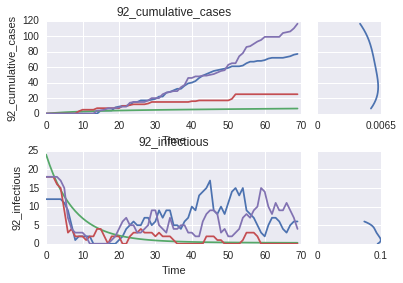

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

from ema_workbench.util import ema_logging, load_results

from ema_workbench.analysis import plotting, plotting_util
from ema_workbench.analysis.plotting import lines 
from ema_workbench.analysis.plotting_util import KDE

ema_logging.log_to_stderr(ema_logging.INFO)

file_name =  r'./simulation_results/EMA{}test.tar.gz'.format(nr_experiments)
results = load_results(file_name)

# the plotting functions return the figure and a dict of axes
plotting.lines(results,  outcomes_to_show = ['92_cumulative_cases','92_infectious' ], density=plotting_util.KDE)
plt.show()

In [9]:
exp, out = results

In [10]:
pd.DataFrame.from_records(exp)

,simultanousAct,breeding_site_recreation_rich,fkt_gradient,share_reported_cases,personal_protection_rich,personal_protection_poor,transmission_prob,fkt_diminisher,Switch_flights,m_prob_reproduce,...,extrinsic_incubation_period,recovery_period,share_herd_immunity,delaytime_reporting,destruction_time_ponds,breeding_site_recreation_poor,network_connectivity,network_type,model,policy
0,0,0.013781,2.553994,0.307844,0.822134,0.496963,0.954515,-17.356825,1,0.32068,...,7.801249,6.131121,0.038006,24.54855,20.134177,0.010192,6.448916,1,simpleModel,None
1,0,0.016281,7.528994,0.120344,0.872134,0.129463,0.929515,-14.856825,0,0.20818,...,7.051249,6.881121,0.188006,18.79855,25.884177,0.005192,3.698916,3,simpleModel,None
2,1,0.018781,17.478994,0.682844,0.972134,0.374463,0.904515,-12.356825,1,0.09568,...,5.551249,4.631121,0.088006,7.29855,8.634177,0.012692,5.073916,2,simpleModel,None
3,1,0.011281,12.503994,0.495344,0.922134,0.251963,0.979515,-19.856825,1,0.43318,...,6.301249,5.381121,0.138006,13.04855,14.384177,0.007692,7.823916,0,simpleModel,None


In [ ]:
out.keys()